## Boundless DAS

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "10/05/2023"

### Overview

This tutorial aims to reproduce one key result of [the Boundless DAS paper](https://arxiv.org/pdf/2305.08809). It uses the same pricing tag dataset as in the paper. Additionally, it focuses on finding alignment for the left boundary check only. 

### Set-up

In [2]:
# This library is our indicator that the required installs
# need to be done.
import pyvene



In [3]:
import torch
from tqdm import tqdm, trange
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss
from tutorial_price_tagging_utils import (
    factual_sampler,
    bound_alignment_sampler,
    lower_bound_alignment_example_sampler,
)

from pyvene import (
    IntervenableModel,
    BoundlessRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)
from pyvene import create_llama
from pyvene import set_seed, count_parameters

In [4]:
config, tokenizer, llama = create_llama()
_ = llama.to("cuda")  # single gpu
_ = llama.eval()  # always no grad on the model

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/34 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


loaded model


### Factual performance of instruct-tuned LLaMA-7B

In [5]:
raw_prealign = factual_sampler(tokenizer, 5000, game="pricing_tag")
prealign_dataset = Dataset.from_dict(
    {"input_ids": raw_prealign[0], "labels": raw_prealign[1]}
)
prealign_dataset.set_format("torch", columns=["input_ids", "labels"])
prealign_dataloader = DataLoader(prealign_dataset, batch_size=8)

In [6]:
total_count = 0
correct_count = 0
with torch.no_grad():
    for step, inputs in enumerate(tqdm(prealign_dataloader)):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(llama.device)

        # aligning forward!
        outputs = llama(
            input_ids=inputs["input_ids"],
            labels=inputs["labels"],
        )

        actual_test_labels = inputs["labels"][:, -1]
        pred_test_labels = torch.argmax(outputs.logits[:, -1], dim=-1)

        correct_labels = actual_test_labels == pred_test_labels

        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
current_acc = round(correct_count / total_count, 2)
print(f"[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: {current_acc}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:31<00:00,  6.83it/s]

[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: 0.92


### Create training dataset for our trainable intervention (Boundless DAS)

In [7]:
set_seed(42)

###################
# data loaders
###################
raw_data = bound_alignment_sampler(
    tokenizer, 10000, [lower_bound_alignment_example_sampler]
)

raw_train = (
    raw_data[0][:8000],
    raw_data[1][:8000],
    raw_data[2][:8000],
    raw_data[3][:8000],
)
raw_eval = (
    raw_data[0][8000:9000],
    raw_data[1][8000:9000],
    raw_data[2][8000:9000],
    raw_data[3][8000:9000],
)
raw_test = (
    raw_data[0][9000:],
    raw_data[1][9000:],
    raw_data[2][9000:],
    raw_data[3][9000:],
)
train_dataset = Dataset.from_dict(
    {
        "input_ids": raw_train[0],
        "source_input_ids": raw_train[1],
        "labels": raw_train[2],
        "intervention_ids": raw_train[3],  # we will not use this field
    }
).with_format("torch")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
)
eval_dataset = Dataset.from_dict(
    {
        "input_ids": raw_eval[0],
        "source_input_ids": raw_eval[1],
        "labels": raw_eval[2],
        "intervention_ids": raw_eval[3],  # we will not use this field
    }
).with_format("torch")
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=16,
)
test_dataset = Dataset.from_dict(
    {
        "input_ids": raw_test[0],
        "source_input_ids": raw_test[1],
        "labels": raw_test[2],
        "intervention_ids": raw_test[3],  # we will not use this field
    }
).with_format("torch")
test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
)

### Boundless DAS on Position-aligned Tokens

In [8]:
def simple_boundless_das_position_config(model_type, intervention_type, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                intervention_type,  # intervention type
            ),
        ],
        intervention_types=BoundlessRotatedSpaceIntervention,
    )
    return config


config = simple_boundless_das_position_config(
    type(llama), "block_output", 15
)
intervenable = IntervenableModel(config, llama)
intervenable.set_device("cuda")
intervenable.disable_model_gradients()

In [9]:
t_total = int(len(train_dataloader) * 3)
warm_up_steps = 0.1 * t_total
optimizer_params = []
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    optimizer_params += [{"params": v[0].intervention_boundaries, "lr": 1e-2}]
optimizer = torch.optim.Adam(optimizer_params, lr=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warm_up_steps, num_training_steps=t_total
)


# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -1]
        pred_test_labels = torch.argmax(eval_pred[:, -1], dim=-1)
        correct_labels = actual_test_labels == pred_test_labels
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count / total_count, 2)
    return {"accuracy": accuracy}


epochs = 3
gradient_accumulation_steps = 4
total_step = 0
target_total_step = len(train_dataloader) * epochs
temperature_start = 50.0
temperature_end = 0.1
temperature_schedule = (
    torch.linspace(temperature_start, temperature_end, target_total_step)
    .to(torch.bfloat16)
    .to("cuda")
)
intervenable.set_temperature(temperature_schedule[total_step])


def calculate_loss(logits, labels):
    shift_logits = logits[..., :, :].contiguous()
    shift_labels = labels[..., :].contiguous()
    # Flatten the tokens
    loss_fct = CrossEntropyLoss()
    shift_logits = shift_logits.view(-1, intervenable.model_config.vocab_size)
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = loss_fct(shift_logits, shift_labels)

    for k, v in intervenable.interventions.items():
        boundary_loss = 1.0 * v[0].intervention_boundaries.sum()
    loss += boundary_loss

    return loss

In [10]:
intervenable.model.train()  # train enables drop-off but no grads
print("llama trainable parameters: ", count_parameters(intervenable.model))
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")
for epoch in train_iterator:
    epoch_iterator = tqdm(
        train_dataloader, desc=f"Epoch: {epoch}", position=0, leave=True
    )
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = intervenable(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 80},  # swap 80th token
        )
        eval_metrics = compute_metrics(
            [counterfactual_outputs.logits], [inputs["labels"]]
        )

        # loss and backprop
        loss = calculate_loss(counterfactual_outputs.logits, inputs["labels"])
        loss_str = round(loss.item(), 2)
        epoch_iterator.set_postfix({"loss": loss_str, "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            if not (gradient_accumulation_steps > 1 and total_step == 0):
                optimizer.step()
                scheduler.step()
                intervenable.set_zero_grad()
                intervenable.set_temperature(temperature_schedule[total_step])
        total_step += 1

llama trainable parameters:  0
intervention trainable parameters:  16777218


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [59:11<00:00, 1183.83s/it]


In [11]:
# evaluation on the test set
eval_labels = []
eval_preds = []
base_hstates = []
intrv_hstates = []
with torch.no_grad():
    epoch_iterator = tqdm(test_dataloader, desc=f"Test")
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        base_outputs, counterfactual_outputs = intervenable(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 80},  # swap 80th token
            output_original_output=True,
            output_hidden_states=True,
        )
        eval_labels += [inputs["labels"]]
        eval_preds += [counterfactual_outputs.logits]
        base_hstates.append([h.cpu() for h in base_outputs.hidden_states])
        intrv_hstates.append([h.cpu() for h in counterfactual_outputs.hidden_states])
eval_metrics = compute_metrics(eval_preds, eval_labels)
print(eval_metrics)

Test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:26<00:00,  1.38s/it]

{'accuracy': 0.96}


In [12]:

for layer in range(len(intrv_hstates[0])):
    do_break = False
    for pos in range(intrv_hstates[0][layer].shape[1]):
        if not torch.all( intrv_hstates[0][layer][:,pos] == base_hstates[0][layer][:,pos] ):
            d = base_hstates[0][layer].shape[-1]
            natty_states = [base_hstates[i][layer][:,pos].reshape(-1,d) for i in range(len(base_hstates))]
            intrv_states = [intrv_hstates[i][layer][:,pos].reshape(-1,d) for i in range(len(base_hstates))]
            print("L:", layer, "Pos:", pos)
            do_break = True
            break
    if do_break: break
natty_states = torch.vstack(natty_states)
intrv_states = torch.vstack(intrv_states)
print(intrv_states.shape)

L: 16 Pos: 80
torch.Size([1000, 4096])



Natty: torch.Size([1000, 4096])
Intrv: torch.Size([1000, 4096])


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_vecs = torch.tensor(vecs[:len(natty_states)])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intrv_vecs = torch.tensor(vecs[len(natty_states):])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:162: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float()
/home/grantsrb/src/pyvene_fork/divergenc

Top Expl Vars: tensor([0.2313, 0.1214, 0.0928, 0.0554, 0.0444])
Vis Expl Vars: tensor(0.2313) tensor(0.1214)


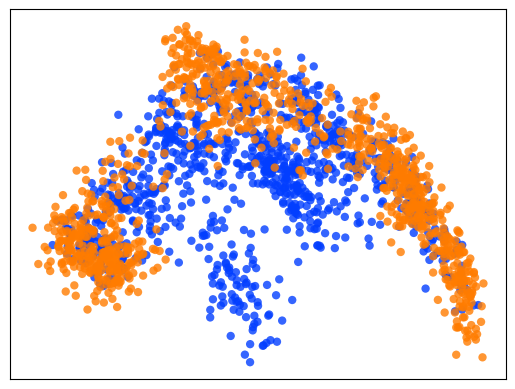

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  natty_vecs = torch.tensor(vecs[:len(natty_states)])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intrv_vecs = torch.tensor(vecs[len(natty_states):])
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:162: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expl_vars = torch.tensor(ret["proportion_expl_var"]).float()


NameError: name 'pd' is not defined

In [14]:
import os
import pandas as pd
import numpy as np
from divergence_utils import visualize_states
np.random.seed(12345)
torch.manual_seed(12345)

n_samples = 10
d = natty_states.shape[-1]

print()
print("Natty:", natty_states.shape)
print("Intrv:", intrv_states.shape)
emd_df_dict = {
    "sample_id": [],
    "mse": [],
    "emd": [],
    "base_emd": [],
}
for samp_id in range(n_samples):
    diffs = visualize_states(
        natty_states,
        intrv_states,
        xdim=0,
        ydim=1,
        save_name="figs/das_divergence.png",
        expl_var_threshold=0,
        emd_sample_type="permute",
        emd_sample_size=len(natty_states)//2,
        normalize_emd=True,
        visualize=samp_id==0,
    )
    mse = diffs["mse"]
    emd = diffs["emd"]
    base_emd = diffs["base_emd"]
    emd_df_dict["sample_id"].append(samp_id)
    emd_df_dict["emd"].append(emd)
    emd_df_dict["base_emd"].append(base_emd)
    emd_df_dict["mse"].append(mse)
emd_df = pd.DataFrame(emd_df_dict)
emd_df[["base_emd","emd",]].mean()
    

In [17]:
d = dict(emd_df[["base_emd","emd",]].mean())
base_emd = d["base_emd"]
emd = d["emd"]
perc = (emd-base_emd)/base_emd
frac = emd/base_emd
print("EMD %:", perc)
print("EMD Frac:", frac)

EMD %: 1.0037804637407113
EMD Frac: 2.003780463740711


In [21]:
emd_df["method"] = "das"
if not os.path.exists("csvs/"):
    os.mkdir("csvs/")
emd_df.to_csv("csvs/das_emd.csv", header=True, index=False)

In [ ]:
import os
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA
import pandas as pd

print("Natty PCA")
X = np.concatenate([
    natty_states.clone().detach().cpu().float().numpy(),
    intrv_states.clone().detach().cpu().float().numpy(),
], axis=0)
train_X = X
mu = train_X.mean(0)
sig = train_X.std(0)+1e-5
X = (X-mu)/(sig)
train_X = (train_X-mu)/(sig)
pca = PCA()
pca.fit(train_X)

vecs = pca.transform(X)
natty_vecs = torch.tensor(vecs[:len(natty_states)])
intrv_vecs = torch.tensor(vecs[len(natty_states):])

natty_df = {
    "pc0": natty_vecs[:,0],
    "pc1": natty_vecs[:,1],
    "hue": np.ones_like(natty_vecs[:,1]),
}
intrv_df = {
    "pc0": intrv_vecs[:,0],
    "pc1": intrv_vecs[:,1],
    "hue": np.ones_like(natty_vecs[:,1]),
}


interleave_scatter(
    natty_df,
    intrv_df,
    hue=None,
    title="", #f"Neural Space {varb}",
    incl_legend=False,
    save_name=os.path.join(
        "./", f"llama_boundless_pricetag.png",
    )
)



In [42]:
try:
    from geomloss import SamplesLoss
except ModuleNotFoundError:
    !pip install geomloss
    from geomloss import SamplesLoss

kwargs = { "loss": "sinkhorn", "p": 2, "blur": 0.05, }
loss_fn = SamplesLoss(**kwargs)
def get_emd(X,Y):
    return loss_fn(X,Y).item()

perm = torch.randperm(len(natty_vecs)).long()
div = get_emd(natty_vecs, intrv_vecs)
baseline = get_emd(natty_vecs[perm[:len(natty_vecs)//2]], natty_vecs[perm[len(natty_vecs)//2:]]) 
div_fraction = (div-baseline)/baseline
print("Divergence:", div)
print("Baseline:", baseline)
print("% Divergence:", div_fraction)